In [88]:
%matplotlib inline
import numpy as np
import pandas as pd
import time
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from sklearn import model_selection
import pathlib

COORDINATES = ["Xmin", "Ymin", "Xmax", "Ymax"]

In [89]:
votes = pd.read_csv("../raw/train_data.csv").set_index("itemId")

In [90]:
answers = pd.read_csv("../raw/train_answers.csv").set_index("itemId")
# answers.columns = COORDINATES

In [91]:
votes_test = pd.read_csv("../raw/test_data.csv").set_index("itemId")

In [181]:
def rated_mean():
    data = votes.join(answers, on="itemId")
    data = pd.concat([data, votes_test], axis=0, sort=False)
    data["se"] = np.median(np.abs(data.iloc[:, -4:].values - data.iloc[:, -8:-4].values), axis=1)
    se_all = data["se"].median()
    rate = data.groupby("userId").se.median().fillna(se_all)
    data["userId"] = data.userId.apply(lambda x: 1 / rate[x])
    data = data.iloc[:, :5].replace(np.inf, 10 ** 10)
    return data.groupby("itemId").apply(lambda x: pd.Series(np.sum(x.values[:, 1:] * x.values[:, :1], axis=0) / np.sum(x.values[:, 0]), index=COORDINATES))

In [266]:
def make_feat(df):
    counts = df["userId"].groupby("itemId").count()
    std = df.groupby("itemId")[COORDINATES].std()
    mean = df.groupby("itemId")[COORDINATES].mean()
    median = df.groupby("itemId")[COORDINATES].median()
    qu = df.groupby("itemId")[COORDINATES].quantile([i / 10 for i in range(11) if i != 5]).unstack()
    return pd.concat([median, qu, std], axis=1)

In [102]:
def intersection_over_union(boxes_pred, boxes_true):

    x_min = K.stack([boxes_pred[:, 0], boxes_true[:, 0]], axis=-1)
    y_min = K.stack([boxes_pred[:, 1], boxes_true[:, 1]], axis=-1)
    x_max = K.stack([boxes_pred[:, 2], boxes_true[:, 2]], axis=-1)
    y_max = K.stack([boxes_pred[:, 3], boxes_true[:, 3]], axis=-1)

    x_min = K.max(x_min, axis=-1)
    y_min = K.max(y_min, axis=-1)
    x_max = K.min(x_max, axis=-1)
    y_max = K.min(y_max, axis=-1)

    zeros = K.zeros_like(x_max)

    x_inter = K.stack([zeros, x_max - x_min], axis=-1)
    y_inter = K.stack([zeros, y_max - y_min], axis=-1)

    x_inter = K.max(x_inter, axis=-1)
    y_inter = K.max(y_inter, axis=-1)
    inter_area = x_inter * y_inter
    
    area_pred = (K.max(K.stack([zeros, boxes_pred[:, 2] - boxes_pred[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_pred[:, 3] - boxes_pred[:, 1]], axis=-1), axis=-1))
    area_true = (K.max(K.stack([zeros, boxes_true[:, 2] - boxes_true[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_true[:, 3] - boxes_true[:, 1]], axis=-1), axis=-1))

    iou = inter_area / (area_pred + area_true - inter_area + K.epsilon())
    
    return -K.mean(iou, axis=-1)

In [268]:
def make_model(units):
    K.clear_session()
    
    y = x = layers.Input(shape=(48,))
    
    y_rez = layers.Lambda(lambda x: x[:, :4])(y)
    
    y = layers.Dense(
        units=units * 8,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=units * 4,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=units * 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=units,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=4,
        activation=None
    )(y)
    y = layers.add([y_rez, y])
    y = layers.Activation("relu")(y)
    
    model = models.Model(inputs=x, outputs=y)
    model.summary()
    return model

In [275]:
def train_model(batch_size, units, epochs=100):
    model = make_model(units)
    
    lr=0.0002
    
    # Предварительное обучение на MAE
    model.compile(optimizer=optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss=intersection_over_union,
                  metrics=None
    )
    cb = [
        callbacks.ModelCheckpoint("../processed/model.h5", monitor="val_loss", verbose=1, save_best_only=True),
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs // 10, verbose=10),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1, verbose=1)
    ]
    rez = model.fit(
        x= make_feat(votes),
        y=answers,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=cb,
        validation_data=[make_feat(votes), answers],
    )
    return rez, model

In [277]:
rez, model = train_model(1, 32)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          12544       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           8256        dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

943/943 [==============================] - 2s 2ms/step - loss: -0.5832 - val_loss: -0.5856

Epoch 00028: val_loss improved from -0.58385 to -0.58564, saving model to ../processed/model.h5
Epoch 29/100
943/943 [==============================] - 2s 2ms/step - loss: -0.5834 - val_loss: -0.5857

Epoch 00029: val_loss improved from -0.58564 to -0.58567, saving model to ../processed/model.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0995115007972345e-05.
Epoch 30/100
943/943 [==============================] - 2s 2ms/step - loss: -0.5843 - val_loss: -0.5863

Epoch 00030: val_loss improved from -0.58567 to -0.58632, saving model to ../processed/model.h5
Epoch 31/100
943/943 [==============================] - 2s 2ms/step - loss: -0.5844 - val_loss: -0.5870

Epoch 00031: val_loss improved from -0.58632 to -0.58696, saving model to ../processed/model.h5
Epoch 32/100
943/943 [==============================] - 2s 2ms/step - loss: -0.5850 - val_loss: -0.5859

Epoch 00032: val_loss 

943/943 [==============================] - 2s 2ms/step - loss: -0.5893 - val_loss: -0.5893

Epoch 00063: val_loss did not improve from -0.58932

Epoch 00063: ReduceLROnPlateau reducing learning rate to 5.192297294343007e-08.
Epoch 64/100
943/943 [==============================] - 2s 2ms/step - loss: -0.5893 - val_loss: -0.5893

Epoch 00064: val_loss improved from -0.58932 to -0.58932, saving model to ../processed/model.h5

Epoch 00064: ReduceLROnPlateau reducing learning rate to 4.153837949161243e-08.
Epoch 65/100
943/943 [==============================] - 2s 2ms/step - loss: -0.5893 - val_loss: -0.5893

Epoch 00065: val_loss did not improve from -0.58932

Epoch 00065: ReduceLROnPlateau reducing learning rate to 3.323070245642157e-08.
Epoch 66/100
943/943 [==============================] - 2s 2ms/step - loss: -0.5893 - val_loss: -0.5893

Epoch 00066: val_loss improved from -0.58932 to -0.58933, saving model to ../processed/model.h5

Epoch 00066: ReduceLROnPlateau reducing learning rate

943/943 [==============================] - 2s 2ms/step - loss: -0.5893 - val_loss: -0.5893

Epoch 00094: val_loss improved from -0.58933 to -0.58933, saving model to ../processed/model.h5

Epoch 00094: ReduceLROnPlateau reducing learning rate to 6.427754439819467e-11.
Epoch 95/100
943/943 [==============================] - 2s 2ms/step - loss: -0.5893 - val_loss: -0.5893

Epoch 00095: val_loss did not improve from -0.58933

Epoch 00095: ReduceLROnPlateau reducing learning rate to 5.142203329810968e-11.
Epoch 96/100
943/943 [==============================] - 2s 2ms/step - loss: -0.5893 - val_loss: -0.5893

Epoch 00096: val_loss did not improve from -0.58933

Epoch 00096: ReduceLROnPlateau reducing learning rate to 4.113762663848775e-11.
Epoch 97/100
943/943 [==============================] - 2s 2ms/step - loss: -0.5893 - val_loss: -0.5893

Epoch 00097: val_loss did not improve from -0.58933

Epoch 00097: ReduceLROnPlateau reducing learning rate to 3.2910102421013225e-11.
Epoch 98/100
943

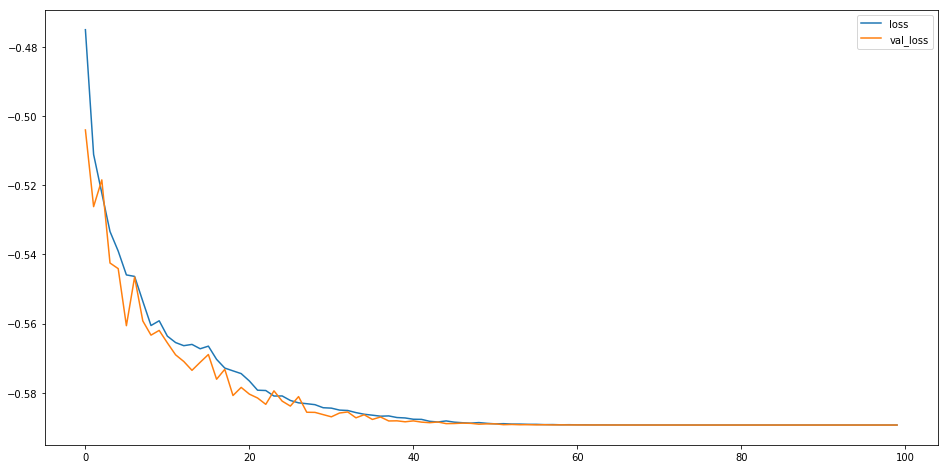

In [278]:
pd.DataFrame(rez.history)[["loss", "val_loss"]].plot(figsize=(16, 8))

In [279]:
def make_forecast(model):
    subdir = time.strftime('%Y-%m-%d_%H-%M')
    path = pathlib.Path(f"../processed/{subdir}")
    path.mkdir(exist_ok=True)
    feat = make_feat(votes_test)
    df = model.predict(feat)
    df = pd.DataFrame(df, index=feat.index)
    df.to_csv(path / "_sub_full.csv", header=False)
    # path.rename(path.parent / f"{subdir}-{score:0.1f}")

In [280]:
make_forecast(model)